# Predicting Structural Outcomes of Lipidated Elastin-Like Peptides Using ESM2 Embeddings

**Abstract:** This notebook implements a machine learning classifier to predict the structural outcomes (droplet, fiber, or metastable) of lipidated elastin-like peptides (ELPs) based on protein language model embeddings from ESM2. We compare three embedding strategies and evaluate their performance on a dataset of 75 peptide variants.

## 1. Background

### 1.1 Biological Context

Lipidated elastin-like peptides (ELPs) are synthetic biopolymers that can self-assemble into various structures depending on their sequence composition. The peptides in this study share a common backbone sequence:

```
G[XXX]SRGSSGSSG[VGVP]×31GWP
```

Where `[XXX]` represents a variable 3-amino acid lipidation site at the N-terminus. The identity of these three residues determines the structural outcome:

- **Droplet**: Forms liquid-like condensates
- **Fiber**: Forms fibrillar/amyloid-like structures  
- **Metastable**: Exhibits intermediate or transitional behavior

### 1.2 Approach

We use ESM2, a protein language model trained on millions of protein sequences, to generate embeddings that capture the biochemical properties of each peptide variant. We compare three embedding strategies:

1. **Mean embeddings**: Average representation across all residues (1,280 features)
2. **Lipid site embeddings**: Per-residue embeddings for positions 2, 3, 4 only (3,840 features)
3. **Combined embeddings**: Concatenation of mean + lipid site embeddings (5,120 features)

## 2. Setup and Imports

In [1]:
# Standard libraries
import os
import pickle
import warnings
from pathlib import Path
from typing import Dict, List, Tuple

# Data handling
import numpy as np
import pandas as pd
import torch

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_curve, auc
)
from sklearn.pipeline import Pipeline

# Dimensionality reduction
import umap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ============================================================================
# Matplotlib & Seaborn Configuration
# ============================================================================

# Set seaborn style
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)

# Global matplotlib parameters
plt.rcParams.update({
    # Figure settings
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,

    # Font settings
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica'],
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 12,

    # Axes settings
    'axes.linewidth': 1.0,
    'axes.edgecolor': '#333333',
    'axes.labelcolor': '#333333',
    'axes.spines.top': False,
    'axes.spines.right': False,

    # Grid settings
    'axes.grid': False,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5,

    # Tick settings
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.color': '#333333',
    'ytick.color': '#333333',

    # Legend settings
    'legend.frameon': False,
    'legend.numpoints': 1,
    'legend.scatterpoints': 1,
})

# Define consistent color palette for structural classes
CLASS_COLORS = {
    'droplet': '#1f77b4',      # Professional blue
    'fiber': '#d62728',        # Professional red
    'metastable': '#ff7f0e'    # Professional orange
}

# Embedding comparison colors (for bar charts)
EMBEDDING_COLORS = ['#2ca02c', '#9467bd', '#8c564b']  # Green, purple, brown

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Configuration complete.")

Configuration complete.


In [3]:
# Define paths
NOTEBOOK_DIR = Path(os.getcwd())
DATA_DIR = NOTEBOOK_DIR / "data"
FIGURES_DIR = NOTEBOOK_DIR / "figures"

# Create figures directory if it doesn't exist
FIGURES_DIR.mkdir(exist_ok=True)

# File paths
LABELS_CSV = DATA_DIR / "sequence_labels.csv"
FASTA_FILE = DATA_DIR / "all_sequences.fasta"

# Embedding directories (containing .pt files from ESM2 extraction)
EMBEDDINGS_LIPID_SITES_DIR = DATA_DIR / "embeddings_lipid_sites"

print(f"Data directory: {DATA_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"Labels file: {LABELS_CSV}")
print(f"Embeddings directory: {EMBEDDINGS_LIPID_SITES_DIR}")

Data directory: /Users/robscrutton/Documents/LipidationPredictions/data
Figures directory: /Users/robscrutton/Documents/LipidationPredictions/figures
Labels file: /Users/robscrutton/Documents/LipidationPredictions/data/sequence_labels.csv
Embeddings directory: /Users/robscrutton/Documents/LipidationPredictions/data/embeddings_lipid_sites


## 3. Data Loading

In [4]:
# Load sequence labels
labels_df = pd.read_csv(LABELS_CSV)

print(f"Loaded {len(labels_df)} sequences")
print(f"\nColumns: {labels_df.columns.tolist()}")
print(f"\nClass distribution:")
print(labels_df['structural_class'].value_counts())

Loaded 75 sequences

Columns: ['sequence_id', 'structural_class']

Class distribution:
structural_class
droplet       41
fiber         27
metastable     7
Name: count, dtype: int64


In [5]:
def load_embeddings_from_pt_files(
    embedding_dir: Path,
    labels_df: pd.DataFrame,
    layer: int = 33,
    include_mean: bool = True,
    include_lipid_sites: bool = True
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Load embeddings from .pt files and align with labels.
    
    Args:
        embedding_dir: Directory containing .pt embedding files
        labels_df: DataFrame with sequence_id and structural_class columns
        layer: Which representation layer to use
        include_mean: Include mean-pooled representation
        include_lipid_sites: Include per-residue lipid site embeddings
    
    Returns:
        X: Feature matrix (n_samples, n_features)
        y: Labels array
        sequence_ids: List of sequence IDs
    """
    labels_dict = dict(zip(labels_df['sequence_id'], labels_df['structural_class']))
    
    embeddings = []
    labels = []
    sequence_ids = []
    
    for seq_id, label in labels_dict.items():
        pt_file = embedding_dir / f"{seq_id}.pt"
        
        if not pt_file.exists():
            print(f"Warning: Embedding file not found for {seq_id}")
            continue
        
        try:
            data = torch.load(pt_file, map_location='cpu')
            
            parts = []
            
            # Add mean representation
            if include_mean and 'mean_representations' in data:
                mean_emb = data['mean_representations'][layer].numpy()
                parts.append(mean_emb)
            
            # Add lipid site representations
            if include_lipid_sites and 'lipid_site_representations' in data:
                for pos in [2, 3, 4]:
                    pos_key = f'position_{pos}'
                    if pos_key in data['lipid_site_representations']:
                        site_emb = data['lipid_site_representations'][pos_key][layer].numpy()
                        parts.append(site_emb)
            
            if parts:
                embedding = np.concatenate(parts)
                embeddings.append(embedding)
                labels.append(label)
                sequence_ids.append(seq_id)
                
        except Exception as e:
            print(f"Error loading {seq_id}: {e}")
    
    X = np.array(embeddings)
    y = np.array(labels)
    
    return X, y, sequence_ids

In [6]:
# Load all three embedding types
print("Loading embeddings...\n")

# Combined embeddings (mean + lipid sites)
print("1. Loading combined embeddings (mean + lipid sites)...")
X_combined, y, sequence_ids = load_embeddings_from_pt_files(
    EMBEDDINGS_LIPID_SITES_DIR,
    labels_df,
    include_mean=True,
    include_lipid_sites=True
)
print(f"   Shape: {X_combined.shape}")

# Mean only
print("2. Loading mean embeddings only...")
X_mean, _, _ = load_embeddings_from_pt_files(
    EMBEDDINGS_LIPID_SITES_DIR,
    labels_df,
    include_mean=True,
    include_lipid_sites=False
)
print(f"   Shape: {X_mean.shape}")

# Lipid sites only
print("3. Loading lipid site embeddings only...")
X_lipid, _, _ = load_embeddings_from_pt_files(
    EMBEDDINGS_LIPID_SITES_DIR,
    labels_df,
    include_mean=False,
    include_lipid_sites=True
)
print(f"   Shape: {X_lipid.shape}")

print(f"\nLoaded {len(y)} sequences with embeddings")
print(f"Classes: {np.unique(y)}")

Loading embeddings...

1. Loading combined embeddings (mean + lipid sites)...
   Shape: (75, 5120)
2. Loading mean embeddings only...
   Shape: (75, 1280)
3. Loading lipid site embeddings only...
   Shape: (75, 3840)

Loaded 75 sequences with embeddings
Classes: ['droplet' 'fiber' 'metastable']


## 4. Exploratory Data Analysis

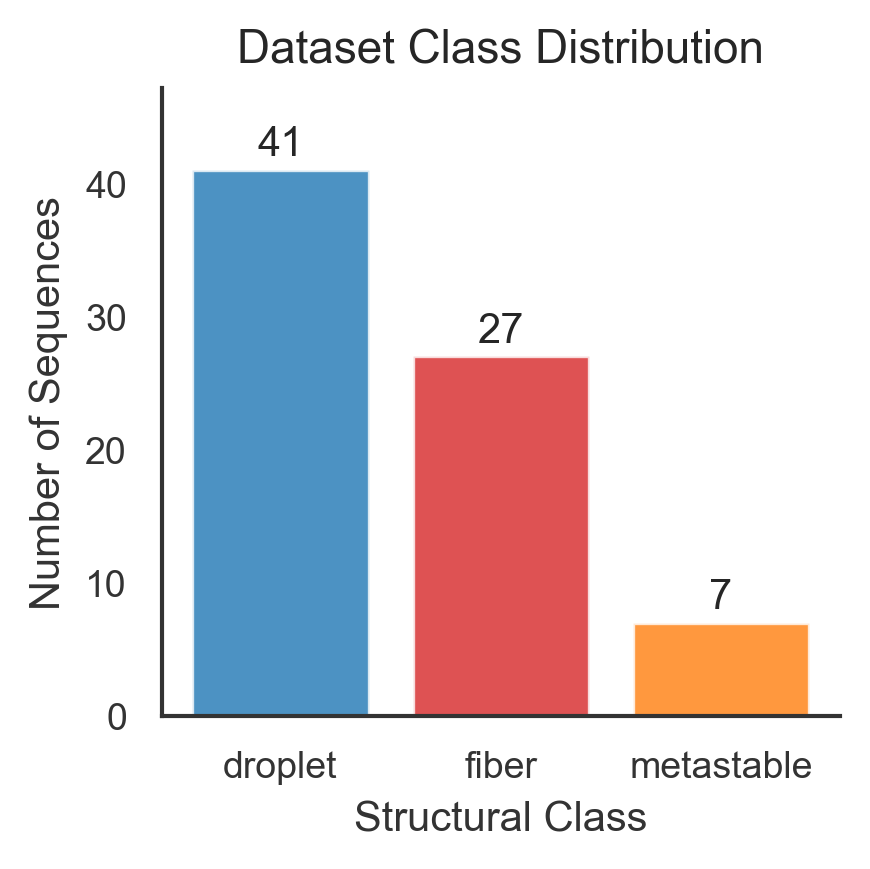

In [7]:
# Class distribution visualization
fig, ax = plt.subplots(figsize=(3, 3))

class_counts = pd.Series(y).value_counts()
bar_colors = [CLASS_COLORS[c] for c in class_counts.index]

bars = ax.bar(class_counts.index, class_counts.values, color=bar_colors, alpha=0.8)

# Add count labels
for bar, count in zip(bars, class_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(count), ha='center', va='bottom')

ax.set_xlabel('Structural Class')
ax.set_ylabel('Number of Sequences')
ax.set_title('Dataset Class Distribution')
ax.set_ylim(0, max(class_counts.values) * 1.15)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'class_distribution.png', bbox_inches='tight')
plt.show()

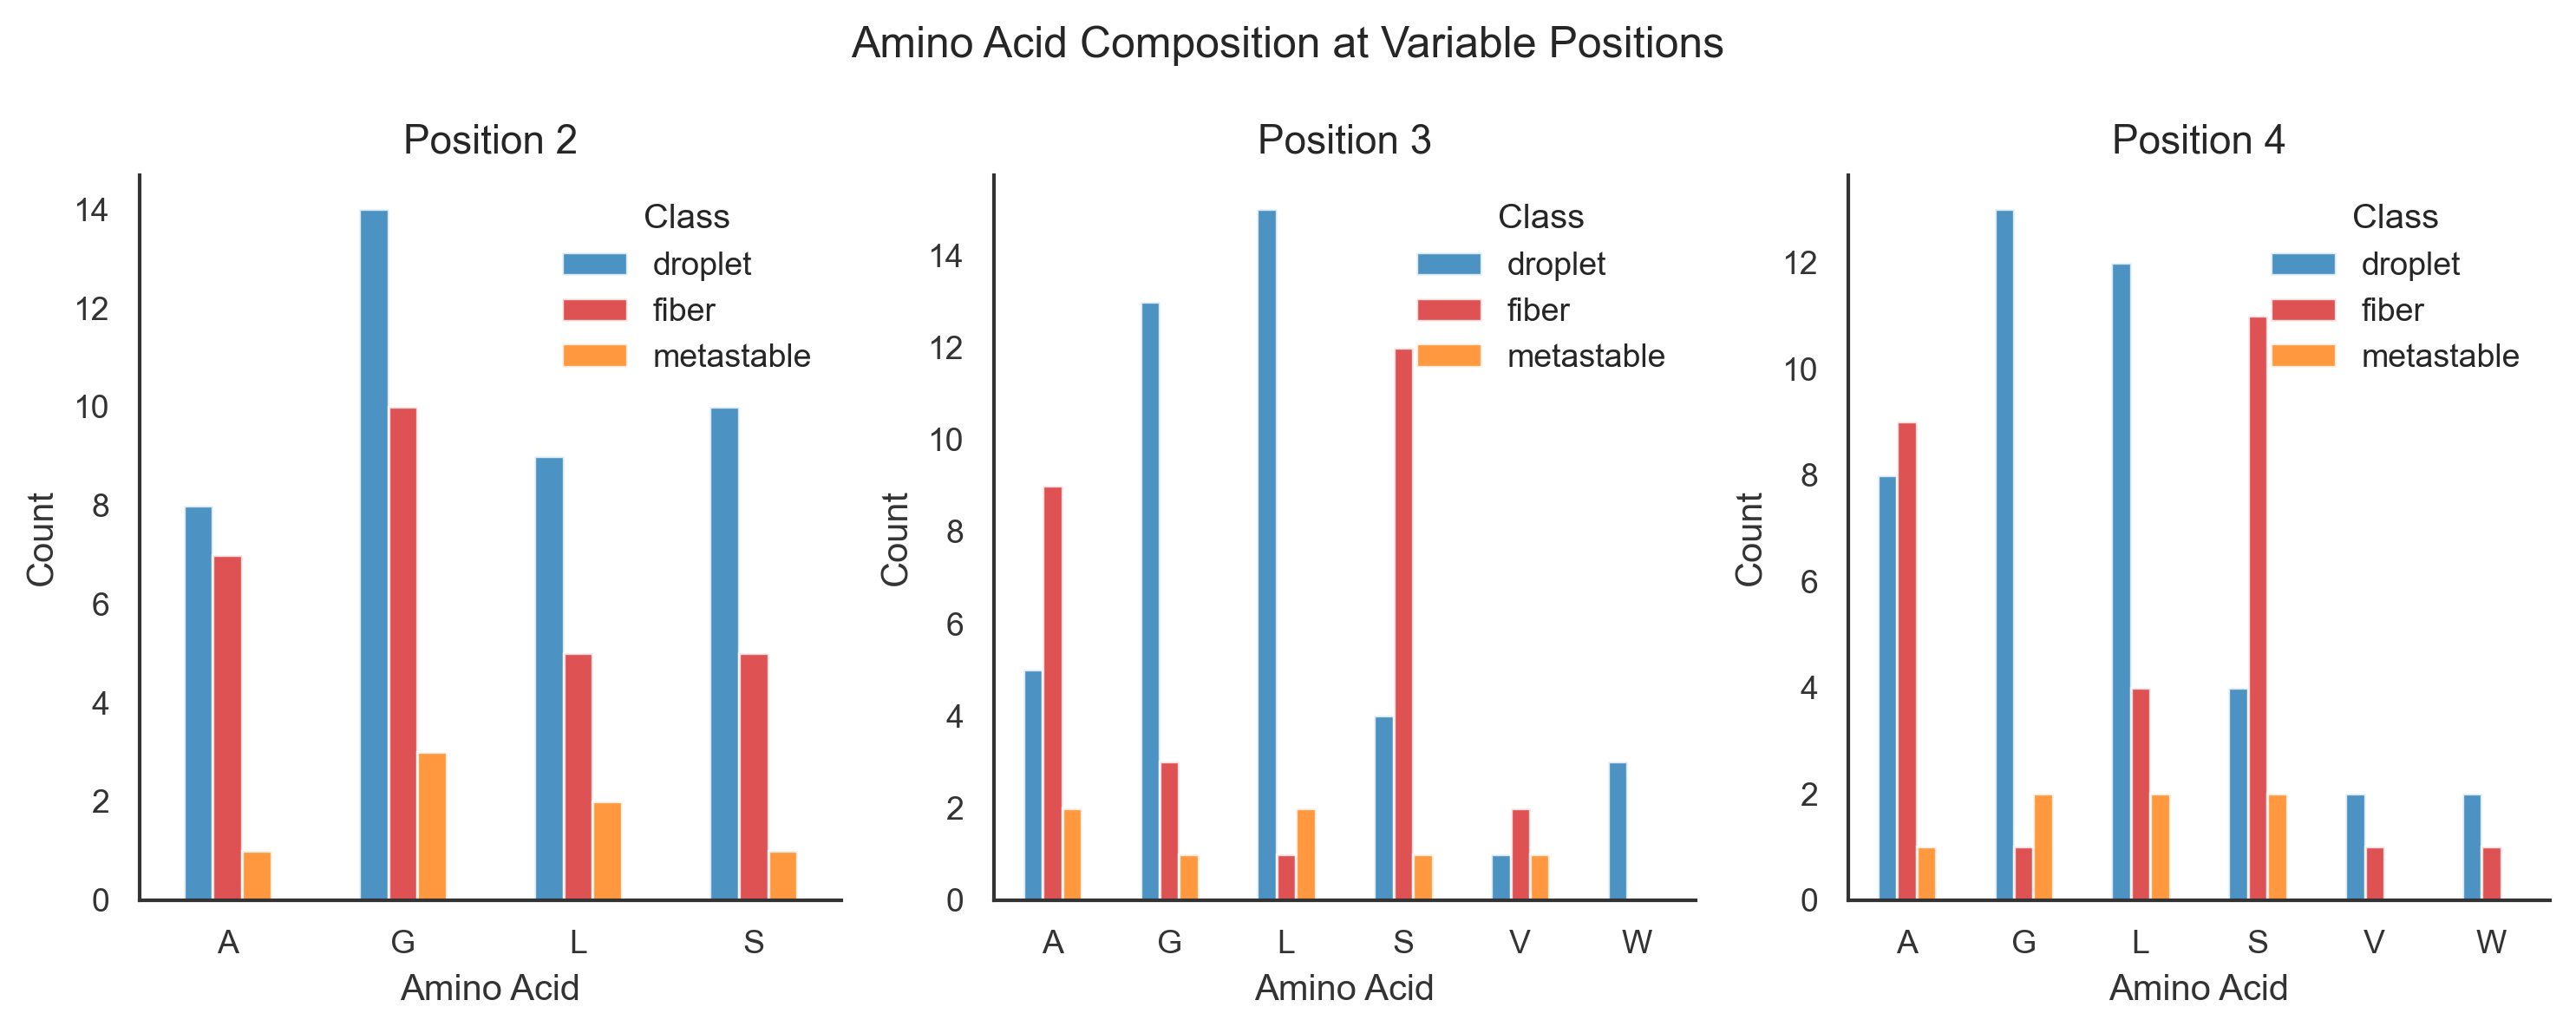

In [8]:
# Analyze amino acid composition at variable positions
def extract_variable_positions(seq_id: str) -> Tuple[str, str, str]:
    """Extract the 3 variable amino acids from sequence ID like G[XYZ]"""
    inner = seq_id[2:-1]  # Extract XYZ from G[XYZ]
    return inner[0], inner[1], inner[2]

# Create composition dataframe
composition_data = []
for seq_id, label in zip(sequence_ids, y):
    pos2, pos3, pos4 = extract_variable_positions(seq_id)
    composition_data.append({
        'sequence_id': seq_id,
        'class': label,
        'pos2': pos2,
        'pos3': pos3,
        'pos4': pos4
    })

comp_df = pd.DataFrame(composition_data)

# Plot amino acid frequencies by position and class
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for idx, pos in enumerate(['pos2', 'pos3', 'pos4']):
    ax = axes[idx]
    
    # Count amino acids by class
    cross_tab = pd.crosstab(comp_df[pos], comp_df['class'])
    cross_tab = cross_tab[['droplet', 'fiber', 'metastable']]  # Reorder columns
    
    cross_tab.plot(kind='bar', ax=ax, 
                   color=[CLASS_COLORS['droplet'], CLASS_COLORS['fiber'], CLASS_COLORS['metastable']], 
                   alpha=0.8)
    
    ax.set_xlabel('Amino Acid')
    ax.set_ylabel('Count')
    ax.set_title(f'Position {idx + 2}')
    ax.tick_params(axis='x', rotation=0)
    ax.legend(title='Class')

plt.suptitle('Amino Acid Composition at Variable Positions')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'amino_acid_composition.png', bbox_inches='tight')
plt.show()

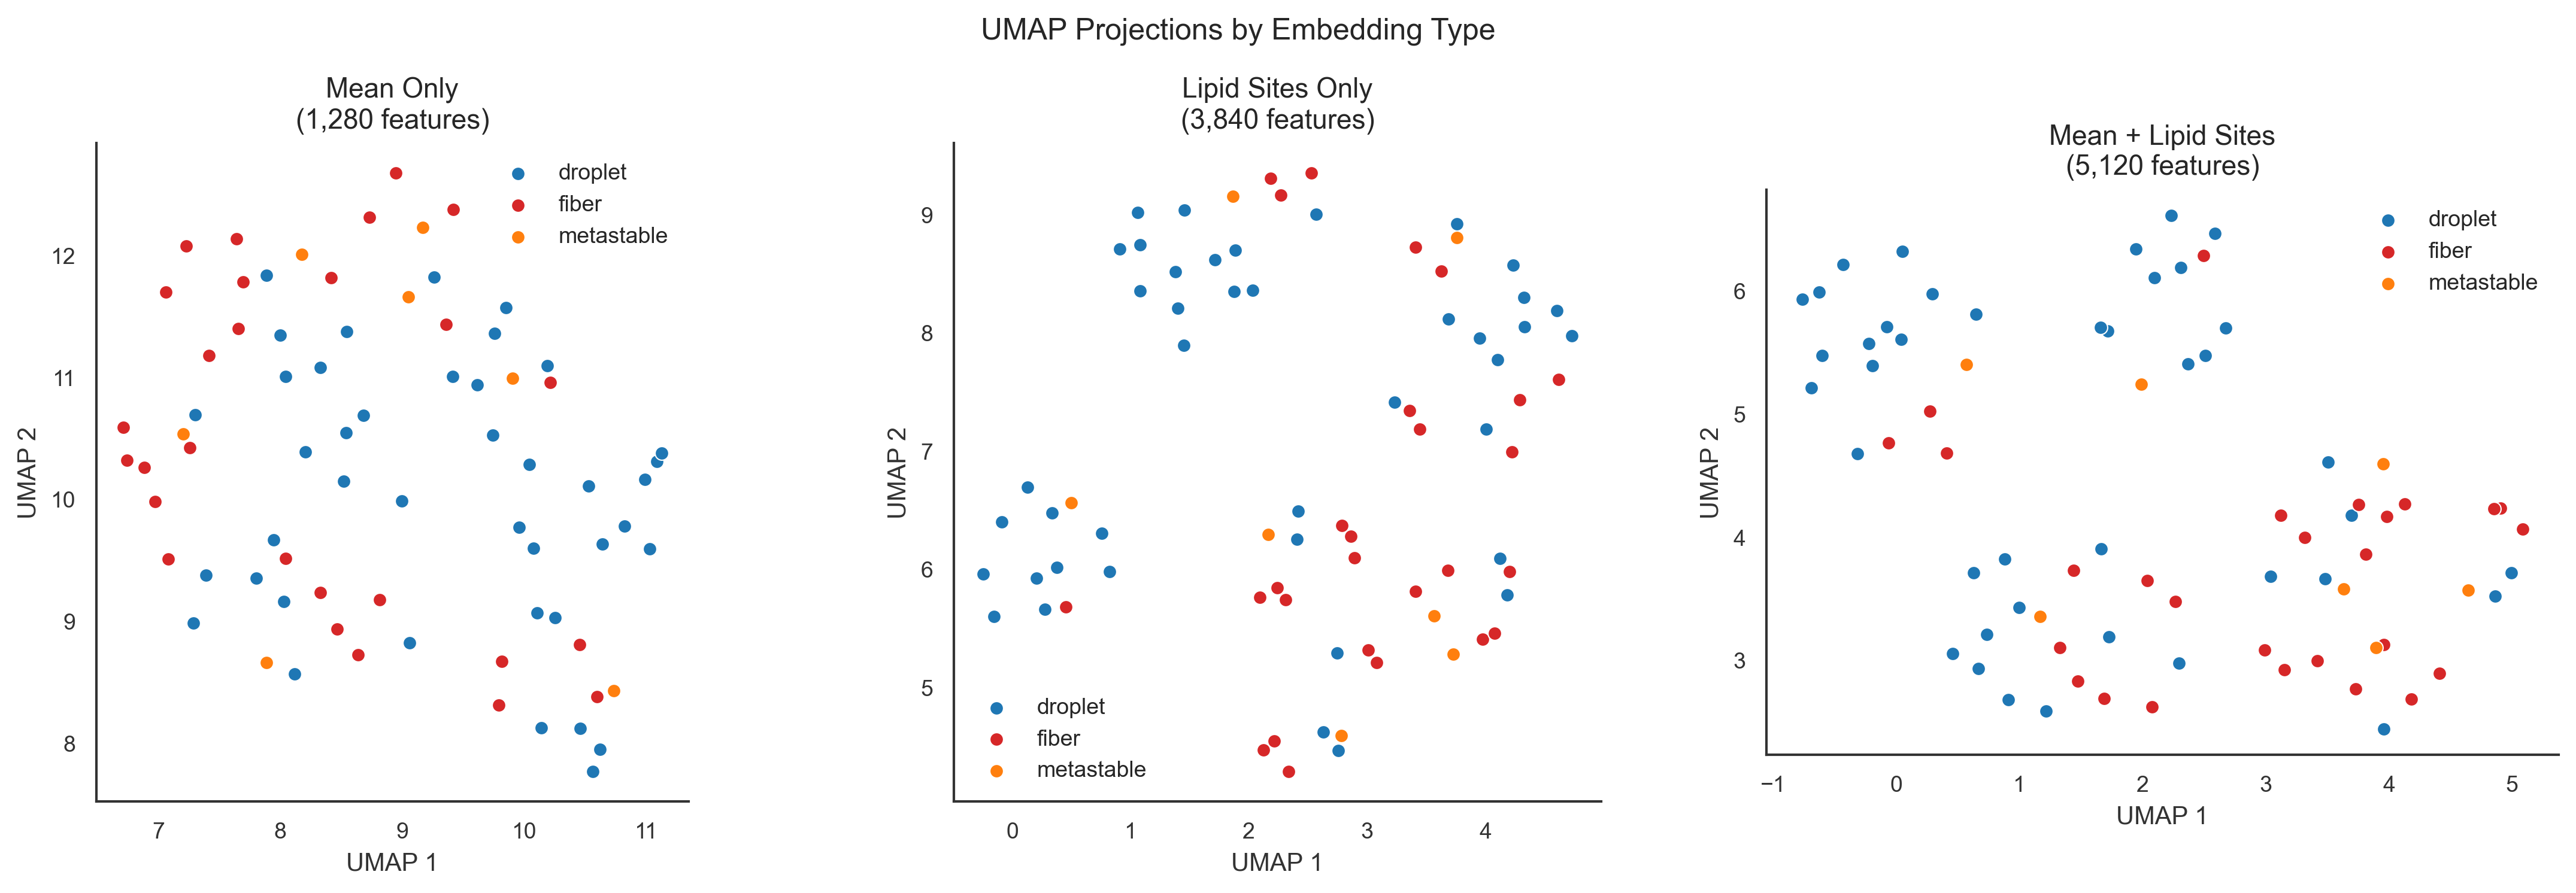

In [9]:
# 2D UMAP visualizations for each embedding type
def create_umap_2d(X: np.ndarray, y: np.ndarray, title: str, ax):
    """Create 2D UMAP visualization"""
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply UMAP
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=RANDOM_STATE)
    X_umap = reducer.fit_transform(X_scaled)
    
    # Plot
    for cls in ['droplet', 'fiber', 'metastable']:
        mask = y == cls
        ax.scatter(X_umap[mask, 0], X_umap[mask, 1],
                   c=CLASS_COLORS[cls], label=cls, alpha=1, s=30,
                   edgecolors='white', linewidth=0.5)
    
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title(title)
    ax.legend()
    ax.set_aspect('equal', adjustable='box')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

embedding_configs = [
    (X_mean, 'Mean Only\n(1,280 features)'),
    (X_lipid, 'Lipid Sites Only\n(3,840 features)'),
    (X_combined, 'Mean + Lipid Sites\n(5,120 features)')
]

for idx, (X, title) in enumerate(embedding_configs):
    create_umap_2d(X, y, title, axes[idx])

plt.suptitle('UMAP Projections by Embedding Type')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'umap_2d_comparison.png', bbox_inches='tight')
plt.show()

## 5. Classification: Comparing Embedding Strategies

In [10]:
# Classification parameters
N_SPLITS = 5

# Random Forest parameters (using standard values to avoid overfitting on small dataset)
RF_PARAMS = {
    'n_estimators': 100,
    'max_depth': 8,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': RANDOM_STATE,
    'class_weight': 'balanced'  # Handle class imbalance
}

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

print(f"Classes: {class_names}")
print(f"Cross-validation: {N_SPLITS}-fold stratified")
print(f"\nNote: Standardization will be applied within each CV fold to prevent data leakage")

Classes: ['droplet' 'fiber' 'metastable']
Cross-validation: 5-fold stratified

Note: Standardization will be applied within each CV fold to prevent data leakage


In [11]:
def train_and_evaluate(X: np.ndarray, y: np.ndarray, name: str) -> Dict:
    """
    Train Random Forest with cross-validation and return metrics.
    
    Note: Standardization is performed within each CV fold to prevent data leakage.
    """
    
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    print(f"Features: {X.shape[1]}")
    
    # Create pipeline with scaler and classifier
    # This ensures scaler is fit inside each CV fold (no data leakage)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(**RF_PARAMS))
    ])
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    
    # Get CV scores - scaler is fit separately in each fold
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)
    y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')
    
    accuracy = cv_scores.mean()
    std = cv_scores.std()
    
    print(f"\nAccuracy: {accuracy:.3f} (+/- {std*2:.3f})")
    print(f"Per-fold scores: {cv_scores.round(3)}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y, y_pred, target_names=class_names))
    
    # Train final model on all data for feature importance and predictions table
    pipeline.fit(X, y)
    
    # Also create separate scaler for compatibility with existing code
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return {
        'name': name,
        'model': pipeline.named_steps['classifier'],  # Extract classifier from pipeline
        'pipeline': pipeline,  # Store full pipeline
        'scaler': scaler,
        'X_scaled': X_scaled,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'cv_scores': cv_scores,
        'accuracy': accuracy,
        'std': std
    }

In [12]:
# Train on all three embedding types
results_mean = train_and_evaluate(X_mean, y_encoded, "Mean Embeddings Only (1,280 features)")
results_lipid = train_and_evaluate(X_lipid, y_encoded, "Lipid Sites Only (3,840 features)")
results_combined = train_and_evaluate(X_combined, y_encoded, "Mean + Lipid Sites (5,120 features)")


Training: Mean Embeddings Only (1,280 features)
Features: 1280

Accuracy: 0.733 (+/- 0.084)
Per-fold scores: [0.733 0.8   0.667 0.733 0.733]

Classification Report:
              precision    recall  f1-score   support

     droplet       0.76      0.85      0.80        41
       fiber       0.69      0.74      0.71        27
  metastable       0.00      0.00      0.00         7

    accuracy                           0.73        75
   macro avg       0.48      0.53      0.51        75
weighted avg       0.66      0.73      0.70        75


Training: Lipid Sites Only (3,840 features)
Features: 3840

Accuracy: 0.747 (+/- 0.229)
Per-fold scores: [0.667 0.733 0.933 0.8   0.6  ]

Classification Report:
              precision    recall  f1-score   support

     droplet       0.74      0.90      0.81        41
       fiber       0.76      0.70      0.73        27
  metastable       0.00      0.00      0.00         7

    accuracy                           0.75        75
   macro avg       

## 6. Results and Visualizations

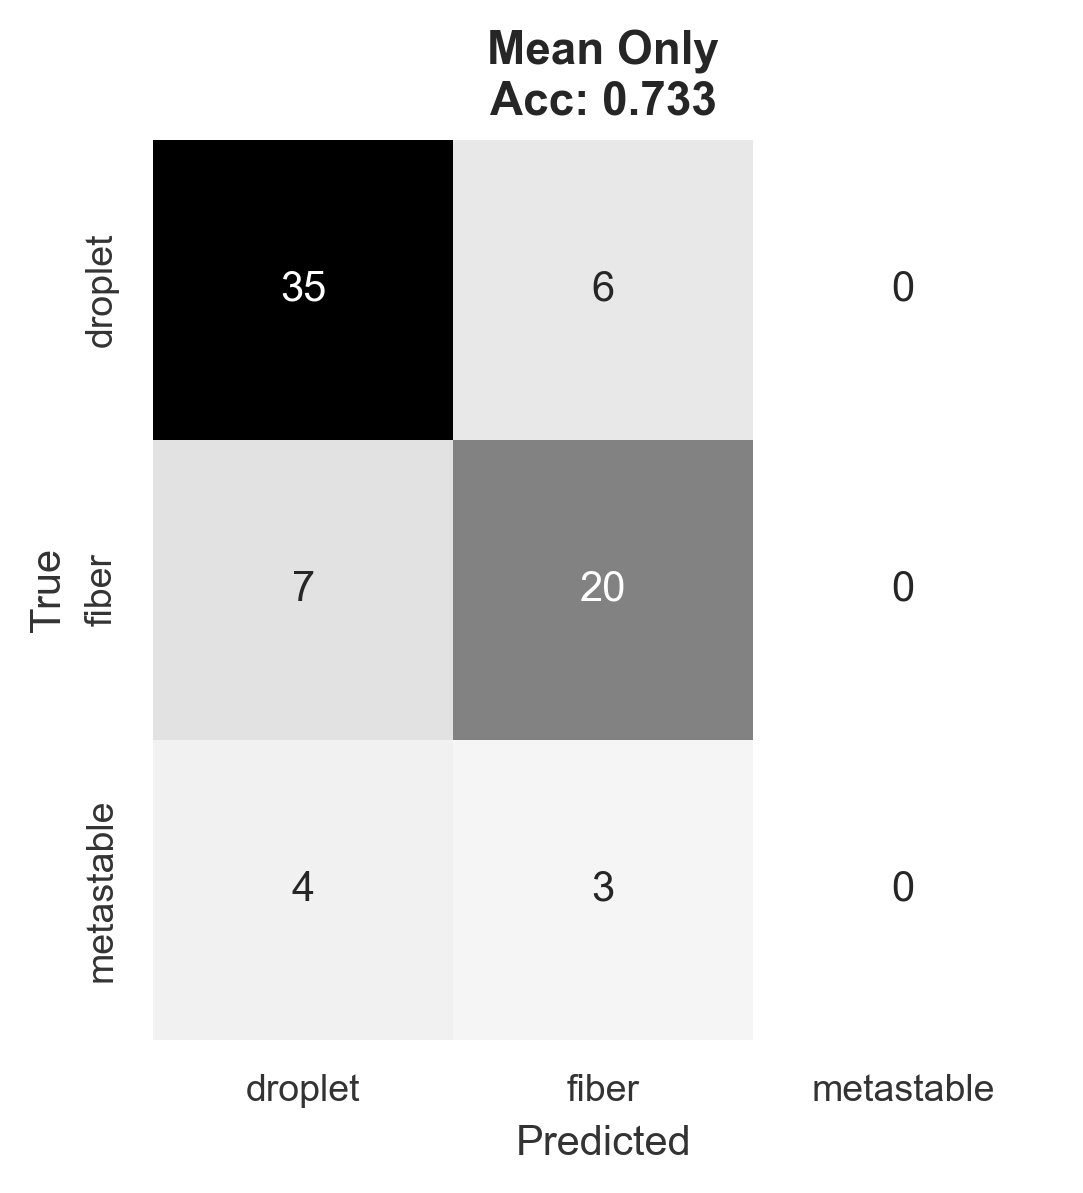

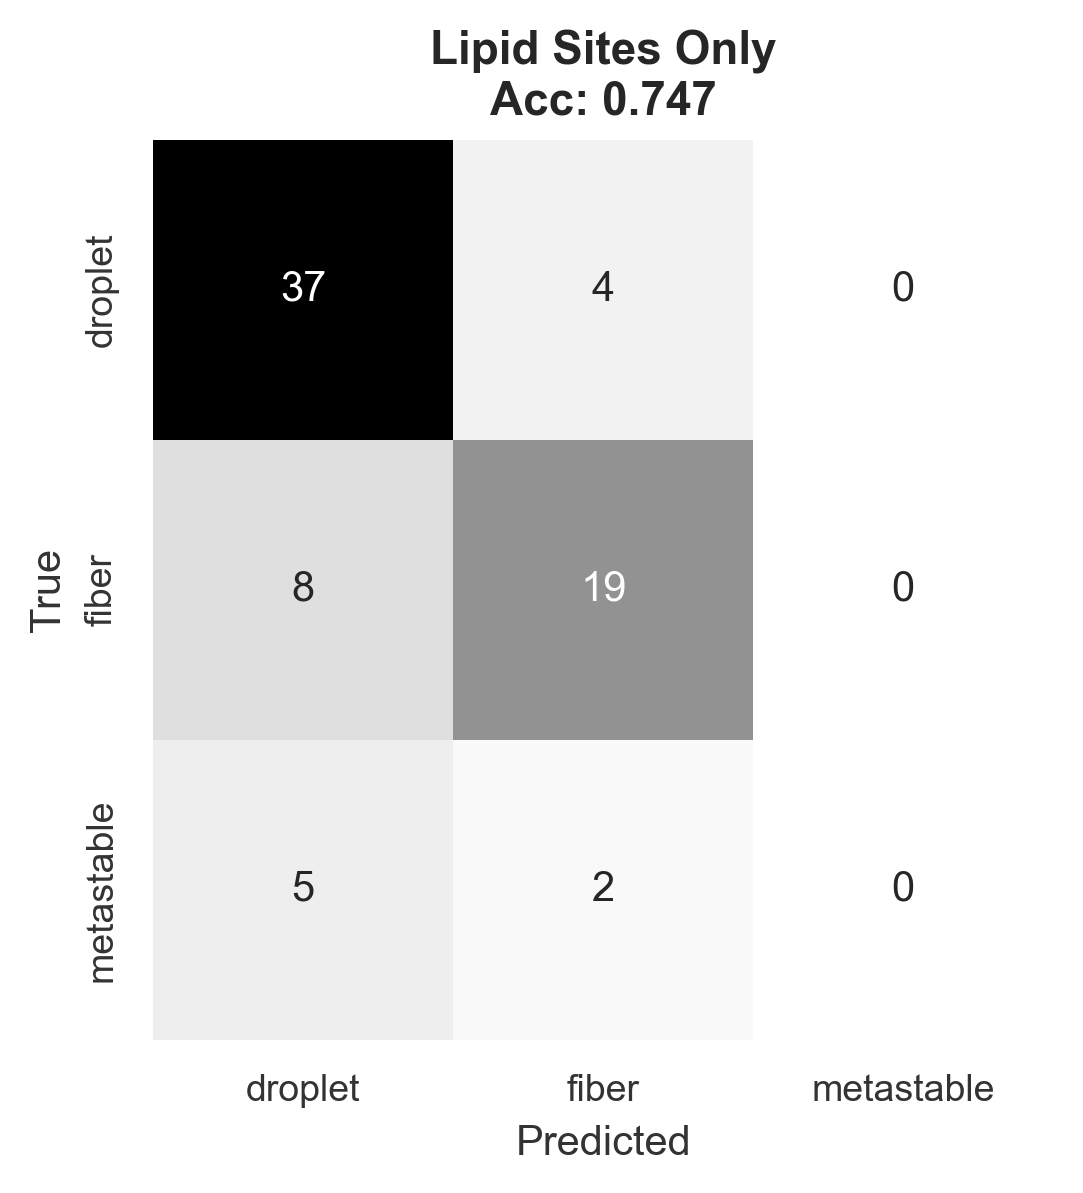

In [13]:
# Confusion matrices (individual plots)
# Only plot Mean Only and Lipid Sites Only
models_to_plot = [
    (results_mean, 'Mean Only'),
    (results_lipid, 'Lipid Sites Only')
]

for results, title in models_to_plot:
    # Create larger figure to accommodate labels and title
    fig = plt.figure(figsize=(4.2, 4.2))
    
    # Set axes to exactly 3x3 inches: [left, bottom, width, height] in figure fraction
    ax = fig.add_axes([0.6/4.2, 0.5/4.2, 3/4.2, 3/4.2])
    
    cm = confusion_matrix(y_encoded, results['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar=False)
    
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.set_title(f'{title}\nAcc: {results["accuracy"]:.3f}', fontsize=11, fontweight='bold')
    
    filename = title.lower().replace(' ', '_')
    plt.savefig(FIGURES_DIR / f'confusion_matrix_{filename}.pdf', dpi=300, bbox_inches='tight')
    plt.show()


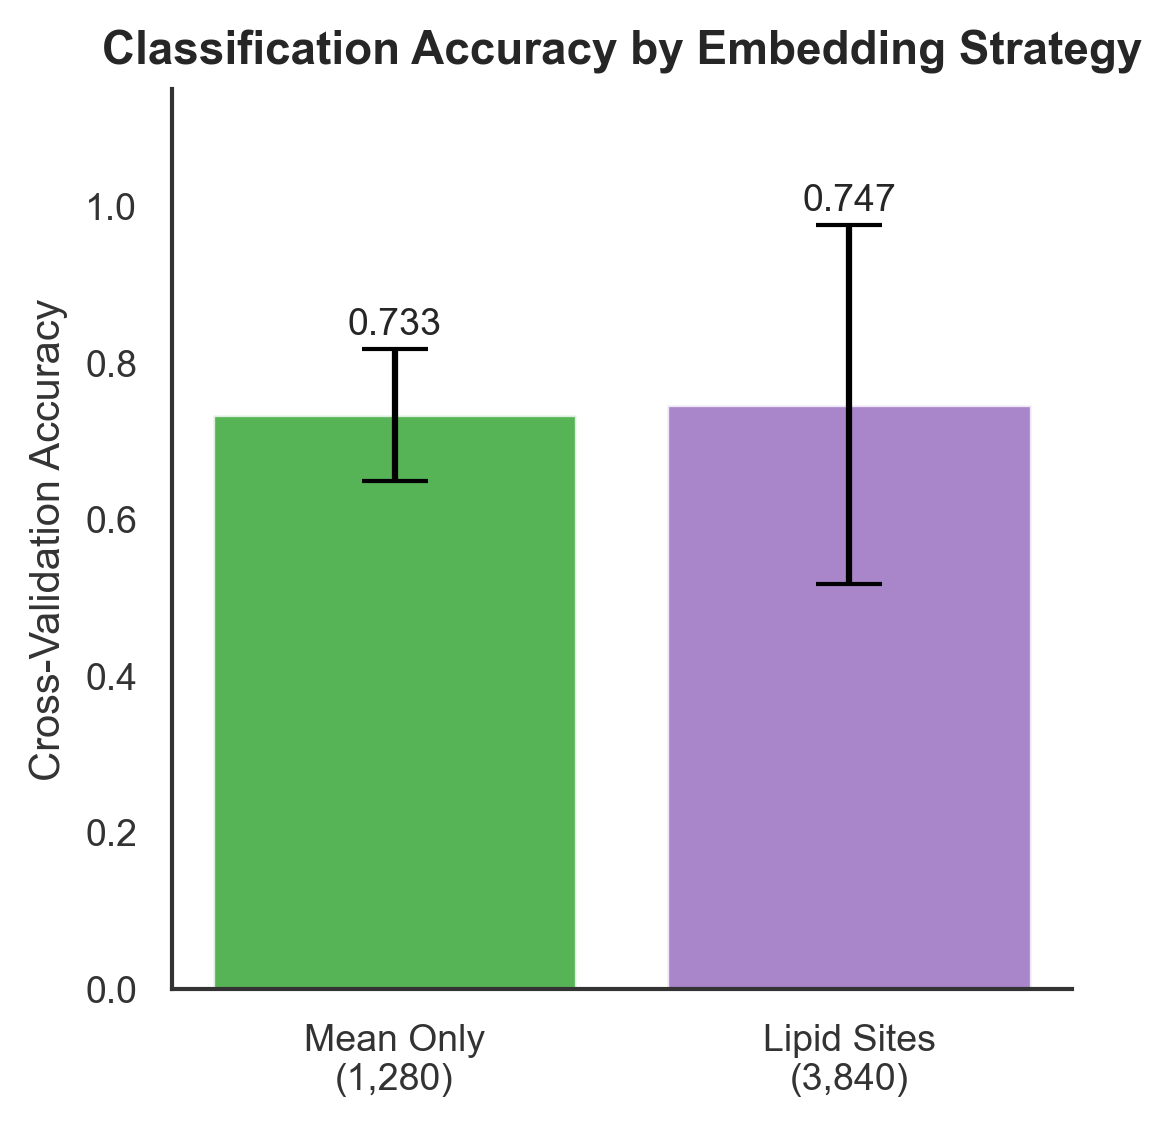

In [14]:
# Overall accuracy comparison
# Create larger figure to accommodate labels
fig = plt.figure(figsize=(4.2, 4.2))

# Set axes to exactly 3x3 inches: [left, bottom, width, height] in figure fraction
ax = fig.add_axes([0.7/4.2, 0.6/4.2, 3/4.2, 3/4.2])

# Only compare Mean Only and Lipid Sites Only
names = ['Mean Only\n(1,280)', 'Lipid Sites\n(3,840)']
accuracies = [results_mean['accuracy'], results_lipid['accuracy']]
stds = [results_mean['std'], results_lipid['std']]

# Use only first two colors from EMBEDDING_COLORS
bars = ax.bar(names, accuracies, color=EMBEDDING_COLORS[:2], alpha=0.8,
              yerr=[s*2 for s in stds], capsize=8, error_kw={'linewidth': 1.5})

# Add value labels
for bar, acc, std in zip(bars, accuracies, stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std*2 + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Cross-Validation Accuracy', fontsize=10)
ax.set_title('Classification Accuracy by Embedding Strategy', fontsize=11, fontweight='bold')
ax.set_ylim(0, 1.15)
ax.tick_params(axis='both', labelsize=9)

plt.savefig(FIGURES_DIR / 'accuracy_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()


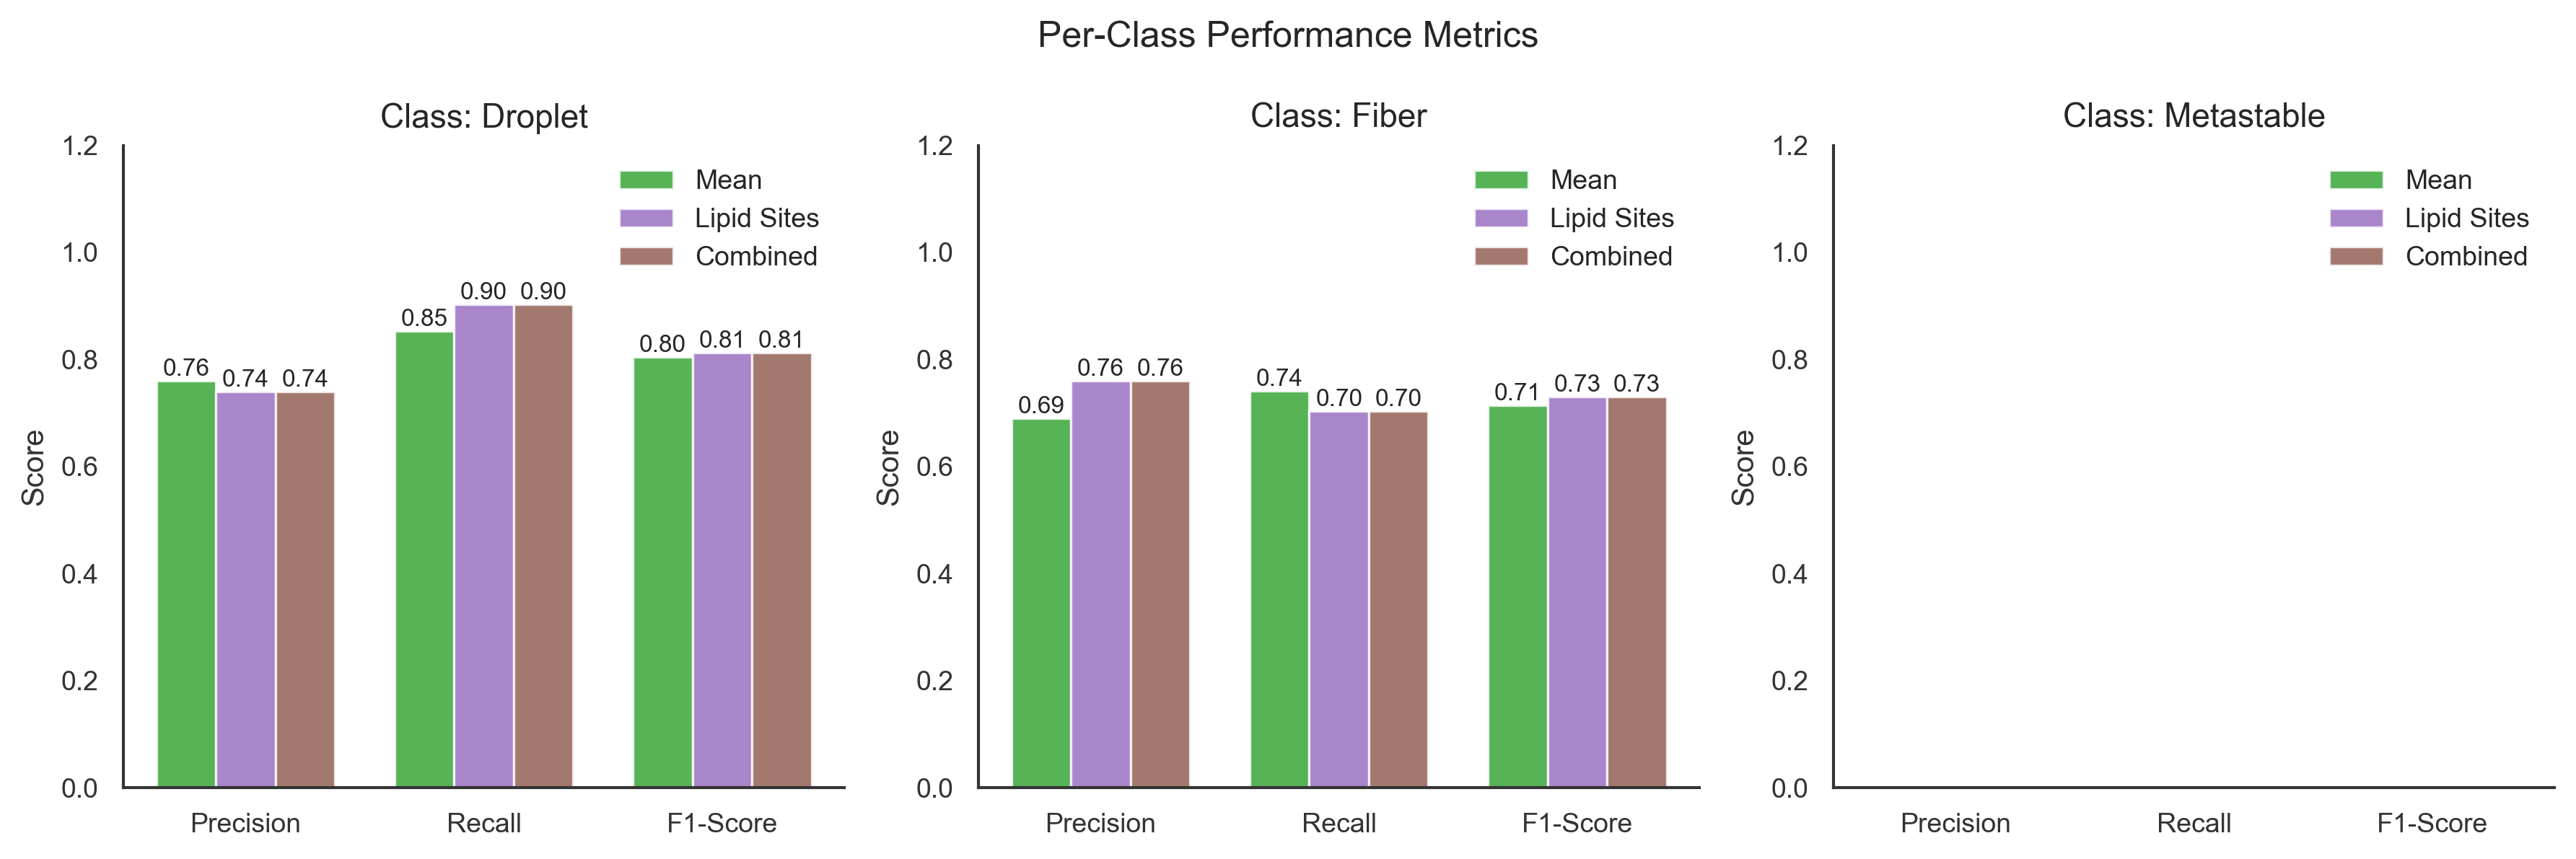

In [15]:
# Per-class performance comparison
def get_per_class_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    return precision, recall, f1

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

metrics_names = ['Precision', 'Recall', 'F1-Score']

for cls_idx, cls_name in enumerate(class_names):
    ax = axes[cls_idx]
    
    x = np.arange(3)  # 3 metrics
    width = 0.25
    
    for emb_idx, (results, emb_name) in enumerate([
        (results_mean, 'Mean'),
        (results_lipid, 'Lipid Sites'),
        (results_combined, 'Combined')
    ]):
        prec, rec, f1 = get_per_class_metrics(y_encoded, results['y_pred'])
        metrics = [prec[cls_idx], rec[cls_idx], f1[cls_idx]]
        
        bars = ax.bar(x + emb_idx * width, metrics, width, 
                      label=emb_name, color=EMBEDDING_COLORS[emb_idx], alpha=0.8)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, height,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_ylabel('Score')
    ax.set_title(f'Class: {cls_name.capitalize()}')
    ax.set_xticks(x + width)
    ax.set_xticklabels(metrics_names)
    ax.set_ylim(0, 1.2)
    ax.legend()

plt.suptitle('Per-Class Performance Metrics')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'per_class_metrics.png', bbox_inches='tight')
plt.show()

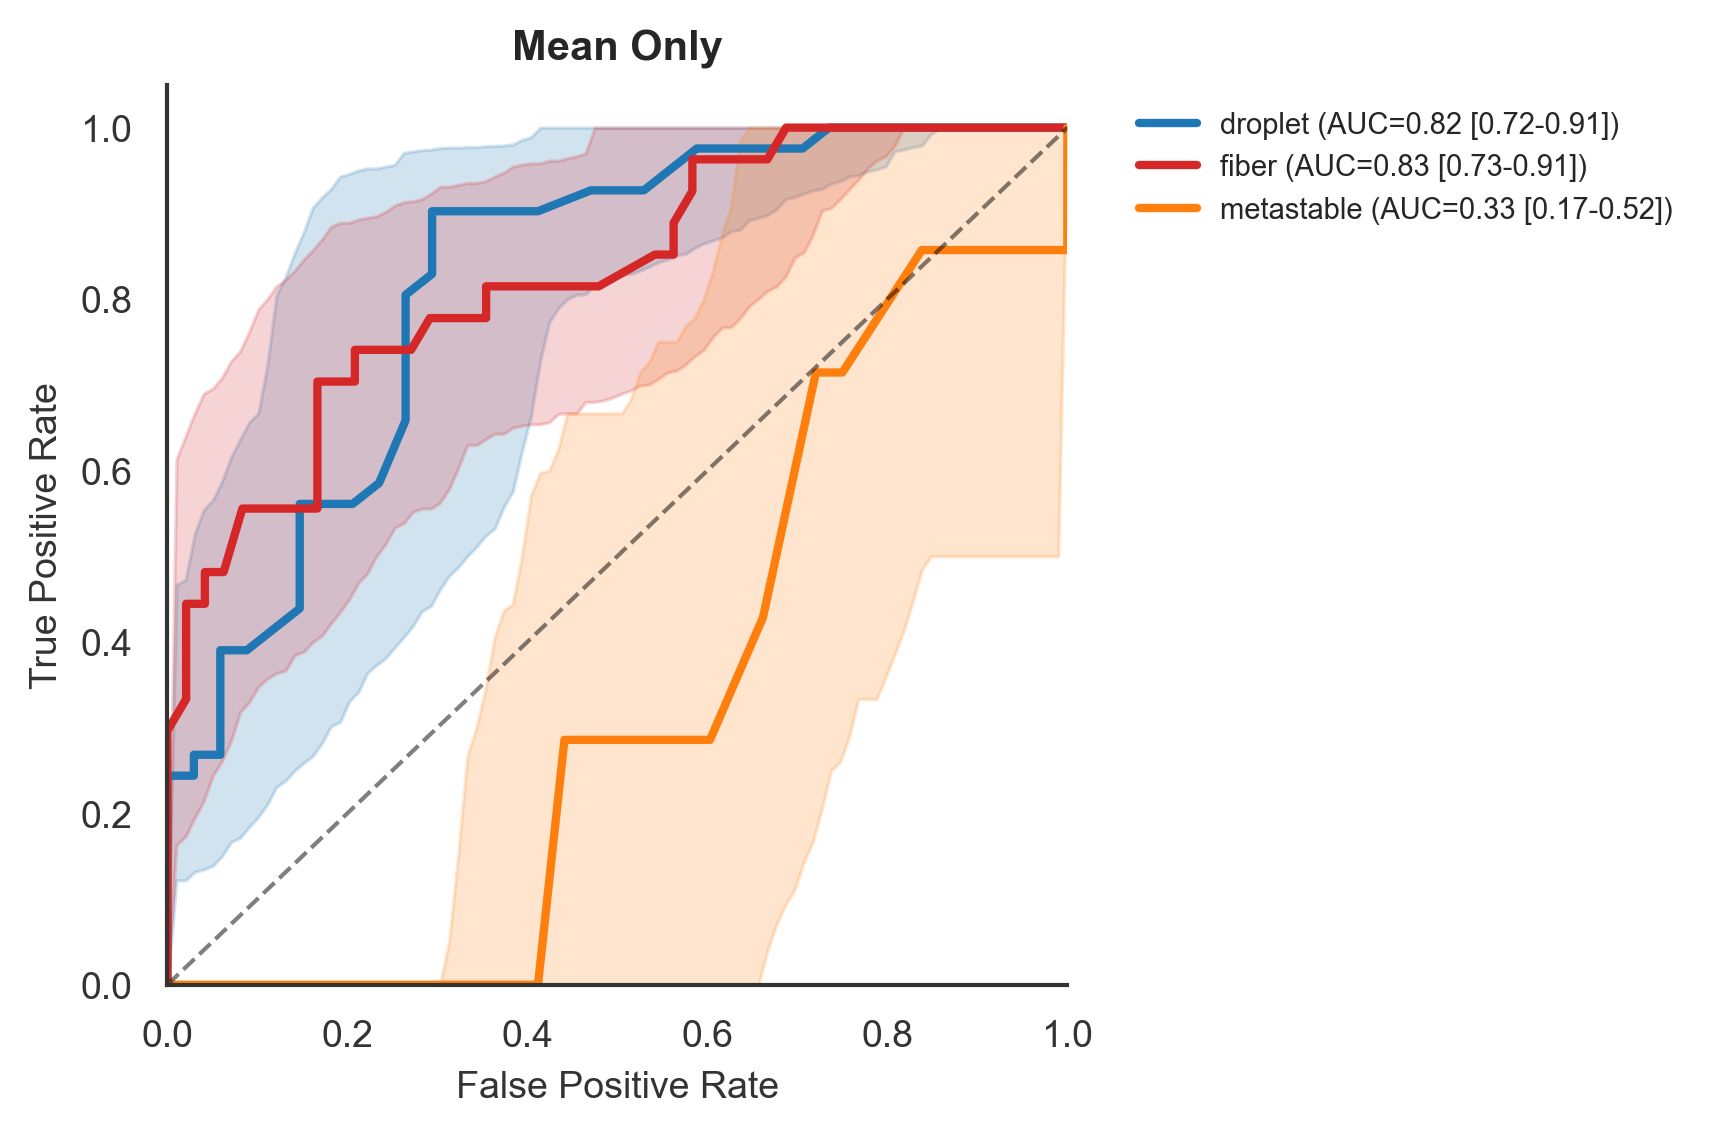

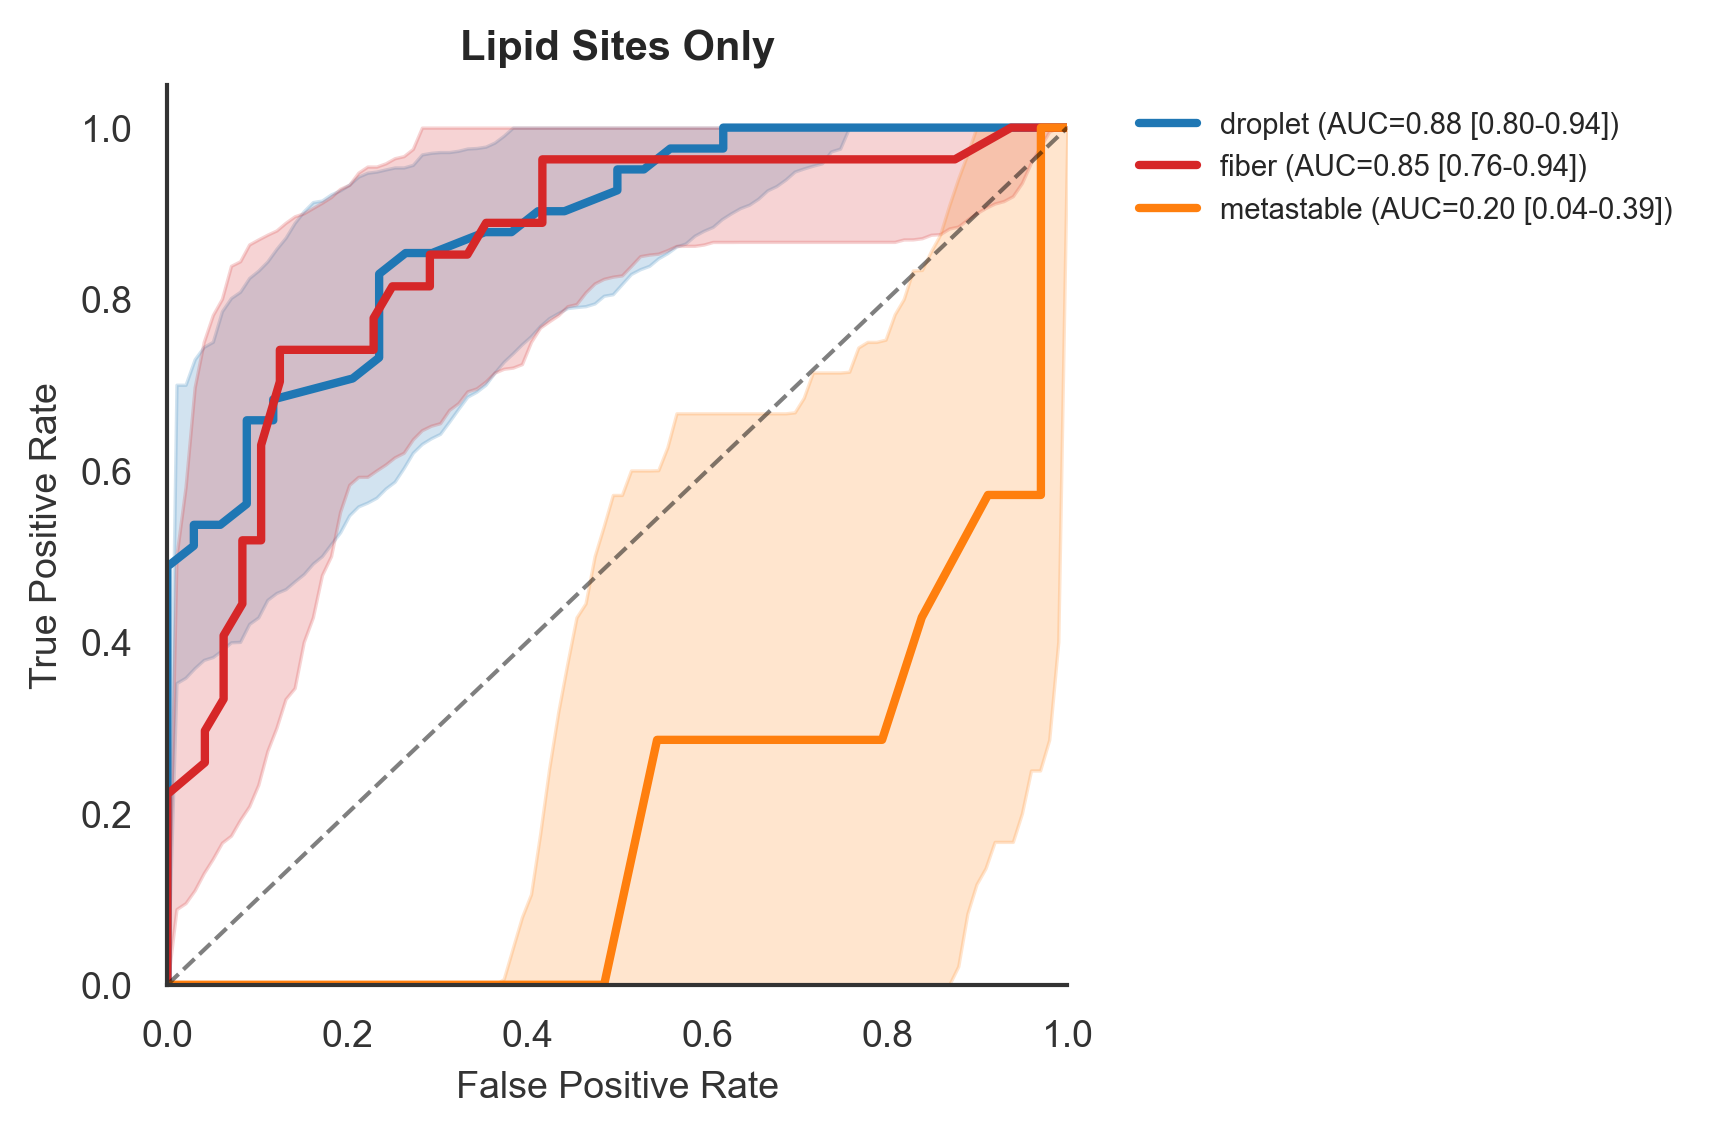

In [17]:
# ROC curves with bootstrap confidence intervals (one-vs-rest for multiclass)
# Binarize labels for ROC
y_bin = label_binarize(y_encoded, classes=[0, 1, 2])

n_bootstraps = 1000
alpha = 0.95

# Only plot Mean Only and Lipid Sites Only
models_to_plot = [
    (results_mean, 'Mean Only'),
    (results_lipid, 'Lipid Sites Only')
]

for results, title in models_to_plot:
    # Create larger figure to accommodate labels and legend
    fig = plt.figure(figsize=(5.5, 3.8))
    
    # Set axes to exactly 3x3 inches: [left, bottom, width, height] in figure fraction
    ax = fig.add_axes([0.6/5.5, 0.6/3.8, 3/5.5, 3/3.8])
    
    for cls_idx, cls_name in enumerate(class_names):
        # Original ROC curve
        fpr, tpr, _ = roc_curve(y_bin[:, cls_idx], results['y_proba'][:, cls_idx])
        roc_auc = auc(fpr, tpr)
        
        # Bootstrap for confidence intervals
        bootstrapped_aucs = []
        tpr_interpolated_list = []
        mean_fpr = np.linspace(0, 1, 100)
        
        rng = np.random.RandomState(42)
        for i in range(n_bootstraps):
            # Resample with replacement
            indices = rng.randint(0, len(y_bin), len(y_bin))
            if len(np.unique(y_bin[indices, cls_idx])) < 2:
                continue
                
            fpr_boot, tpr_boot, _ = roc_curve(y_bin[indices, cls_idx], 
                                               results['y_proba'][indices, cls_idx])
            bootstrapped_aucs.append(auc(fpr_boot, tpr_boot))
            
            # Interpolate TPR at mean FPR points
            tpr_interpolated = np.interp(mean_fpr, fpr_boot, tpr_boot)
            tpr_interpolated[0] = 0.0
            tpr_interpolated_list.append(tpr_interpolated)
        
        # Calculate AUC confidence interval
        auc_ci_lower = np.percentile(bootstrapped_aucs, (1.0 - alpha) / 2 * 100)
        auc_ci_upper = np.percentile(bootstrapped_aucs, (alpha + (1.0 - alpha) / 2) * 100)
        
        # Calculate TPR confidence intervals
        tpr_array = np.array(tpr_interpolated_list)
        tpr_lower = np.percentile(tpr_array, (1.0 - alpha) / 2 * 100, axis=0)
        tpr_upper = np.percentile(tpr_array, (alpha + (1.0 - alpha) / 2) * 100, axis=0)
        
        # Plot ROC curve
        ax.plot(fpr, tpr, color=CLASS_COLORS[cls_name], lw=2, 
                label=f'{cls_name} (AUC={roc_auc:.2f} [{auc_ci_lower:.2f}-{auc_ci_upper:.2f}])')
        
        # Plot confidence interval as shaded area
        ax.fill_between(mean_fpr, tpr_lower, tpr_upper, 
                        color=CLASS_COLORS[cls_name], alpha=0.2)
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    ax.set_xlabel('False Positive Rate', fontsize=9)
    ax.set_ylabel('True Positive Rate', fontsize=9)
    ax.set_title(f'{title}', fontsize=10, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    
    # Legend outside plot (top right) - won't affect the 3x3 plot area
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
    
    filename = title.lower().replace(' ', '_')
    plt.savefig(FIGURES_DIR / f'roc_curve_{filename}_with_ci.pdf', bbox_inches='tight', dpi=300)
    plt.show()


## 7. Summary and Conclusions

In [ ]:
# Summary table
summary_data = {
    'Embedding Type': ['Mean Only', 'Lipid Sites Only', 'Combined'],
    'Features': [1280, 3840, 5120],
    'Accuracy': [f"{r['accuracy']:.3f}" for r in [results_mean, results_lipid, results_combined]],
    'Std': [f"+/-{r['std']*2:.3f}" for r in [results_mean, results_lipid, results_combined]]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("SUMMARY: Classification Performance by Embedding Type")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)

# Find best
best_idx = np.argmax([results_mean['accuracy'], results_lipid['accuracy'], results_combined['accuracy']])
best_names = ['Mean Only', 'Lipid Sites Only', 'Combined']
print(f"\nBest performing embedding: {best_names[best_idx]}")


SUMMARY: Classification Performance by Embedding Type
  Embedding Type  Features Accuracy      Std
       Mean Only      1280    0.733 +/-0.084
Lipid Sites Only      3840    0.747 +/-0.229
        Combined      5120    0.747 +/-0.177

Best performing embedding: Lipid Sites Only


## 8. Appendix: Full Predictions Table

In [23]:
# Create full predictions table using best model
best_results = results_lipid
predictions_df = pd.DataFrame({
    'Sequence': sequence_ids,
    'True_Class': le.inverse_transform(y_encoded),
    'Predicted_Class': le.inverse_transform(best_results['y_pred']),
    'Prob_Droplet': best_results['y_proba'][:, 0].round(3),
    'Prob_Fiber': best_results['y_proba'][:, 1].round(3),
    'Prob_Metastable': best_results['y_proba'][:, 2].round(3)
})

predictions_df['Correct'] = predictions_df['True_Class'] == predictions_df['Predicted_Class']

# Save to CSV
predictions_df.to_csv(FIGURES_DIR / 'predictions_full.csv', index=False)

# Display incorrect predictions
print("Misclassified Sequences:")
print(predictions_df[~predictions_df['Correct']].to_string(index=False))

print(f"\nTotal misclassified: {(~predictions_df['Correct']).sum()} / {len(predictions_df)}")

Misclassified Sequences:
Sequence True_Class Predicted_Class  Prob_Droplet  Prob_Fiber  Prob_Metastable  Correct
  G[ALS] metastable         droplet          0.48        0.43             0.09    False
  G[ASG]      fiber         droplet          0.68        0.29             0.03    False
  G[GAG] metastable         droplet          0.69        0.27             0.04    False
  G[GGA]      fiber         droplet          0.62        0.33             0.05    False
  G[GGG] metastable         droplet          0.74        0.23             0.03    False
  G[GGS]      fiber         droplet          0.48        0.37             0.15    False
  G[GSG]    droplet           fiber          0.32        0.60             0.08    False
  G[GSL]    droplet           fiber          0.27        0.73             0.00    False
  G[LAA] metastable           fiber          0.26        0.73             0.01    False
  G[LAL]      fiber         droplet          0.39        0.25             0.36    False
  G[LLS

In [24]:
# Display full table
print("\nFull Predictions Table:")
predictions_df


Full Predictions Table:


,Sequence,True_Class,Predicted_Class,Prob_Droplet,Prob_Fiber,Prob_Metastable,Correct
0,G[AAA],fiber,fiber,0.24,0.60,0.16,True
1,G[AAG],droplet,droplet,0.42,0.38,0.20,True
2,G[AAL],fiber,fiber,0.43,0.48,0.09,True
3,G[AAS],fiber,fiber,0.16,0.70,0.14,True
4,G[AGA],droplet,droplet,0.61,0.35,0.04,True
...,...,...,...,...,...,...,...
70,G[GWL],droplet,droplet,0.75,0.10,0.15,True
71,G[GWA],droplet,droplet,0.62,0.36,0.02,True
72,G[GLV],droplet,droplet,0.75,0.14,0.11,True
73,G[GWV],droplet,droplet,0.76,0.22,0.02,True
